In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


⚙️ Step 1: Setup & Install Dependencies


In [50]:
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q webcolors matplotlib scikit-learn pillow

  Preparing metadata (setup.py) ... done


⚙️ Step 2: Import Required Libraries


In [51]:
import os
import glob
import torch
import clip
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import webcolors
from IPython.display import display


⚙️ Step 3: Load CLIP Model + Precompute Text Features

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Class labels for object detection
candidate_labels = [
    "a phone", "a wallet", "a set of keys", "a water bottle",
    "sunglasses", "a calculator", "a laptop", "a charger",
    "a backpack", "earphones", "an unknown object"
]

# Precompute text embeddings ONCE
with torch.no_grad():
    text_tokens = torch.cat([clip.tokenize(label) for label in candidate_labels]).to(device)
    text_features = model.encode_text(text_tokens)


⚙️ Step 4: Object Detection Function

In [53]:
def detect_object_clip(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        logits = image_features @ text_features.T
        probs = logits.softmax(dim=-1).cpu().numpy()

    best_idx = np.argmax(probs)
    return candidate_labels[best_idx], probs[0][best_idx]


⚙️ Step 5: Dominant Color + Closest Name

In [55]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import webcolors

# Manually define a CSS3-compatible hex-to-name mapping
css3_hex_to_names = {
    '#000000': 'black', '#000080': 'navy', '#0000ff': 'blue',
    '#008000': 'green', '#008080': 'teal', '#00ff00': 'lime',
    '#00ffff': 'aqua', '#800000': 'maroon', '#800080': 'purple',
    '#808000': 'olive', '#808080': 'gray', '#c0c0c0': 'silver',
    '#ff0000': 'red', '#ff00ff': 'fuchsia', '#ffff00': 'yellow',
    '#ffffff': 'white', '#a52a2a': 'brown', '#d2691e': 'chocolate',
    '#f5f5dc': 'beige', '#f0e68c': 'khaki', '#add8e6': 'lightblue',
    '#d3d3d3': 'lightgray', '#ffb6c1': 'lightpink', '#ffa07a': 'lightsalmon',
    '#20b2aa': 'lightseagreen', '#87cefa': 'lightskyblue', '#778899': 'lightslategray',
    '#b0c4de': 'lightsteelblue', '#ffffe0': 'lightyellow', '#90ee90': 'lightgreen'
}

# Pre-convert to RGB
css3_rgb_names = [(webcolors.hex_to_rgb(h), name) for h, name in css3_hex_to_names.items()]

def detect_dominant_color(image_path, k=3):
    img = Image.open(image_path).convert('RGB').resize((64, 64))
    img_np = np.array(img).reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_np)
    dominant = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
    return tuple(map(int, dominant))

def closest_color(rgb_tuple):
    def distance(c1, c2):
        return sum((a - b) ** 2 for a, b in zip(c1, c2))

    min_dist = float('inf')
    closest_name = None
    for rgb_val, name in css3_rgb_names:
        d = distance(rgb_tuple, rgb_val)
        if d < min_dist:
            min_dist = d
            closest_name = name
    return closest_name


⚙️ Step 6: Process Image Directory

In [56]:
def get_all_images(base_path):
    exts = ["*.jpg", "*.jpeg", "*.png"]
    image_paths = []
    for folder, _, _ in os.walk(base_path):
        for ext in exts:
            image_paths.extend(glob.glob(os.path.join(folder, ext)))
    return image_paths


⚙️ Step 7: Loop Through and Display/Print (demo)

In [57]:
def process_images(base_path, limit=10, show_images=True):
    paths = get_all_images(base_path)
    print(f"Found {len(paths)} images.\n")

    for i, img_path in enumerate(paths[:limit]):
        obj, conf = detect_object_clip(img_path)
        rgb = detect_dominant_color(img_path)
        color_name = closest_color(rgb)

        if show_images:
            display(Image.open(img_path))

        print(f"📦 Detected Object: {obj} ({conf*100:.1f}%)")
        print(f"🎨 Dominant Color: {color_name}")
        print("-" * 50)


⚙️ Step 8: Run the Final Command

Found 45 images.



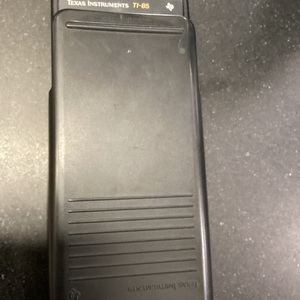

📦 Detected Object: a phone (95.7%)
🎨 Dominant Color: gray
--------------------------------------------------


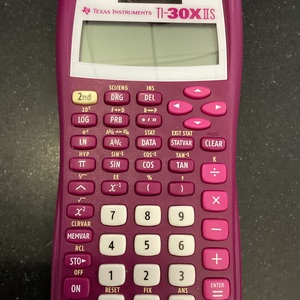

📦 Detected Object: a calculator (99.9%)
🎨 Dominant Color: brown
--------------------------------------------------


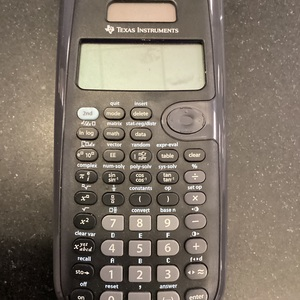

📦 Detected Object: a calculator (83.7%)
🎨 Dominant Color: gray
--------------------------------------------------


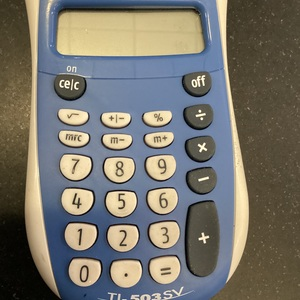

📦 Detected Object: a calculator (96.6%)
🎨 Dominant Color: brown
--------------------------------------------------


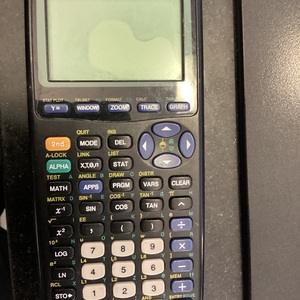

📦 Detected Object: a calculator (94.4%)
🎨 Dominant Color: gray
--------------------------------------------------


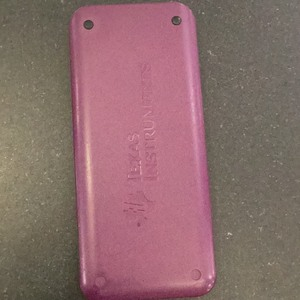

📦 Detected Object: a phone (90.4%)
🎨 Dominant Color: gray
--------------------------------------------------


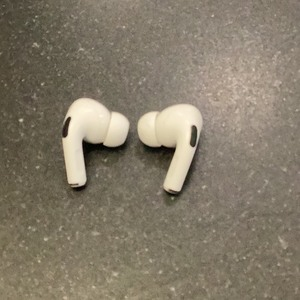

📦 Detected Object: earphones (66.0%)
🎨 Dominant Color: gray
--------------------------------------------------


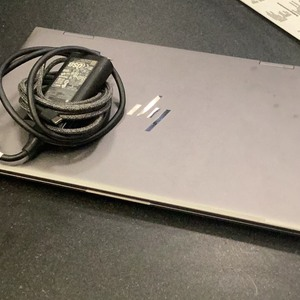

📦 Detected Object: a laptop (92.9%)
🎨 Dominant Color: silver
--------------------------------------------------


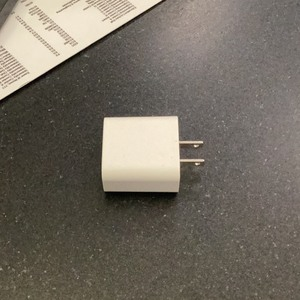

📦 Detected Object: a charger (45.6%)
🎨 Dominant Color: brown
--------------------------------------------------


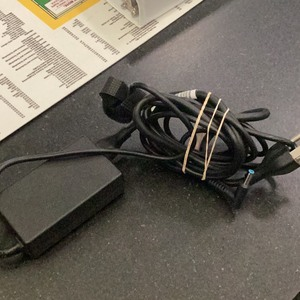

📦 Detected Object: a phone (75.8%)
🎨 Dominant Color: gray
--------------------------------------------------


In [58]:
process_images("/content/drive/MyDrive/project images", limit=10)